## Data Wrangling

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import sample data to 'df' variable
df = pd.read_csv('../raw_data/ski_resort_data.csv')

A good starting approach is as follows:

### 1. Call `df.info()` and `df.head()` to get an overview of the data.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 330 entries, 0 to 329
Data columns (total 27 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               330 non-null    object 
 1   Region             330 non-null    object 
 2   state              330 non-null    object 
 3   summit_elev        330 non-null    int64  
 4   vertical_drop      330 non-null    int64  
 5   base_elev          330 non-null    int64  
 6   trams              330 non-null    int64  
 7   fastEight          164 non-null    float64
 8   fastSixes          330 non-null    int64  
 9   fastQuads          330 non-null    int64  
 10  quad               330 non-null    int64  
 11  triple             330 non-null    int64  
 12  double             330 non-null    int64  
 13  surface            330 non-null    int64  
 14  total_chairs       330 non-null    int64  
 15  Runs               326 non-null    float64
 16  TerrainParks       279 non

### 2. Verify data integrity and check missing values with the following:

In [4]:
# Creating lists of missing data by count and percentage
missing = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
missing.columns=['count', 'percentage']
missing.sort_values(by='count', ascending = False).head(13)

,count,percentage
fastEight,166,50.303030
NightSkiing_ac,143,43.333333
AdultWeekday,54,16.363636
AdultWeekend,51,15.454545
daysOpenLastYear,51,15.454545
TerrainParks,51,15.454545
projectedDaysOpen,47,14.242424
Snow Making_ac,46,13.939394
averageSnowfall,14,4.242424
LongestRun_mi,5,1.515152


Note that sometimes missing data values are encoded with -1, 999, 0, or some value that does not make sense in the context of the column.

Features can be numeric (e.g. `AdultWeekday` and `fastEight` columns), categorical (e.g. `region`), or even both (e.g. month).

### 3. Check for row values that shouldn't be duplicated.  In this case, while we have a ski resort that is duplicated, they refer to different ski resorts.

We see there are 2 Crystal Mountains with the following code:

In [5]:
df['Name'].value_counts().head()

Crystal Mountain    2
Alyeska Resort      1
Brandywine          1
Boston Mills        1
Alpine Valley       1
Name: Name, dtype: int64

We can explore this further, where the notebook suggests the following code to individually check vs 'Region' and vs 'State:

In [6]:
(ski_data['Name'] + ', ' + ski_data['Region']).value_counts().head()
(ski_data['Name'] + ', ' + ski_data['state']).value_counts().head()

NameError: name 'ski_data' is not defined

I prefer to look at that particular tuple:

In [ ]:
df[df['Name']=='Crystal Mountain']

In [ ]:
df[df.state == 'Montana'].set_index('Name').T

### 4.  Check each column variable for extremes and possibly manually correct if necessary.

In [ ]:
df.describe().T

Getting a visual representation of each variable:

In [ ]:
df.hist(figsize=(15,10))
plt.subplots_adjust(hspace=0.5);

There are numerous issues with the data:
1. `summit_elev` - too many values clustered near 0
2. `vertical_drop` - too many values clustered near 0
3. `trams` - too many values clustered near 0
4. `fastEight` - too many values clustered near 0
5. `fastSixes` - too many values clustered near 0
6. `total_chairs` - higher data points seems a bit unreasonable
7. `runs` - higher data points seems a bit unreasonable
8. `SkiableTerrain_ac` - too many values clustered near 0 and the max value seems absurdly high
9. `Snow Making_ac` - too many values clustered near 0 and the max value seems absurdly high
10. `yearsOpen` - too many values clustered near 0 and the max value seems absurdly high 

Looking at  `SkiableTerrain_ac`:

In [ ]:
df[df.SkiableTerrain_ac > 10000].T

A quick search shows that the actual number should be 1819.

In [ ]:
df.loc[39, 'SkiableTerrain_ac'] = 1819
df.loc[39, 'SkiableTerrain_ac']

In [ ]:
df.SkiableTerrain_ac.hist(bins=30)
plt.xlabel('SkiableTerrain_ac')
plt.ylabel('Count')
plt.title('Distribution of skiable area (acres) after replacing erroneous value');

In [ ]:
df[df.SkiableTerrain_ac > 6000].T

Upon search, it appears these values are legitimate.

In [ ]:
df[df.yearsOpen>1000]

### 5. Use aggregations to create relevant summary statistics:

In [ ]:
state_summary = df.groupby('state').agg(
    resorts_per_state=pd.NamedAgg(column='Name', aggfunc='size'), #could pick any column here
    state_total_skiable_area_ac=pd.NamedAgg(column='SkiableTerrain_ac', aggfunc='sum'),
    state_total_days_open=pd.NamedAgg(column='daysOpenLastYear', aggfunc='sum'),
    state_total_terrain_parks=pd.NamedAgg(column='TerrainParks', aggfunc='sum'),
    state_total_nightskiing_ac=pd.NamedAgg(column='NightSkiing_ac', aggfunc='sum')
).reset_index()
state_summary.head()

## Exploratory Data Analysis

In [7]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

from library.sb_utils import save_file

ski_data = pd.read_csv('../data/ski_data_cleaned.csv')
state_summary = pd.read_csv('../data/state_summary.csv')

### 1. Start with .info() and .head().  We can also re-index if summary statistics if appropriate.

In [8]:
state_summary.info()
state_summary.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35 entries, 0 to 34
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   state                        35 non-null     object 
 1   resorts_per_state            35 non-null     int64  
 2   state_total_skiable_area_ac  35 non-null     float64
 3   state_total_days_open        35 non-null     float64
 4   state_total_terrain_parks    35 non-null     float64
 5   state_total_nightskiing_ac   35 non-null     float64
 6   state_population             35 non-null     int64  
 7   state_area_sq_miles          35 non-null     int64  
dtypes: float64(4), int64(3), object(1)
memory usage: 2.3+ KB


,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrain_parks,state_total_nightskiing_ac,state_population,state_area_sq_miles
0,Alaska,3,2280.0,345.0,4.0,580.0,731545,665384
1,Arizona,2,1577.0,237.0,6.0,80.0,7278717,113990
2,California,21,25948.0,2738.0,81.0,587.0,39512223,163695
3,Colorado,22,43682.0,3258.0,74.0,428.0,5758736,104094
4,Connecticut,5,358.0,353.0,10.0,256.0,3565278,5543


In [9]:
state_summary_indexed = state_summary.set_index('state')

### 2. Analyze summary statistics to determine an approach.

In this case,  data was sorted by descending summary statistic/

In [10]:
state_summary_indexed.state_area_sq_miles.sort_values(ascending=False).head()
state_summary_indexed.state_population.sort_values(ascending=False).head()
state_summary_indexed.resorts_per_state.sort_values(ascending=False).head()
state_summary_indexed.state_total_skiable_area_ac.sort_values(ascending=False).head()
state_summary_indexed.state_total_nightskiing_ac.sort_values(ascending=False).head()
state_summary_indexed.state_total_days_open.sort_values(ascending=False).head()

state
Colorado         3258.0
California       2738.0
Michigan         2389.0
New York         2384.0
New Hampshire    1847.0
Name: state_total_days_open, dtype: float64

For a better comparison, we want to look at ratios.  Here is an example which computes ratios and drops columns accordingly.

In [11]:
state_summary['resorts_per_100kcapita'] = 100_000 * state_summary.resorts_per_state / state_summary.state_population
state_summary['resorts_per_100ksq_mile'] = 100_000 * state_summary.resorts_per_state / state_summary.state_area_sq_miles
state_summary.drop(columns=['state_population', 'state_area_sq_miles'], inplace=True)
state_summary.head()

,state,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrain_parks,state_total_nightskiing_ac,resorts_per_100kcapita,resorts_per_100ksq_mile
0,Alaska,3,2280.0,345.0,4.0,580.0,0.410091,0.450867
1,Arizona,2,1577.0,237.0,6.0,80.0,0.027477,1.754540
2,California,21,25948.0,2738.0,81.0,587.0,0.053148,12.828736
3,Colorado,22,43682.0,3258.0,74.0,428.0,0.382028,21.134744
4,Connecticut,5,358.0,353.0,10.0,256.0,0.140242,90.203861


Following is a code example for visualization:

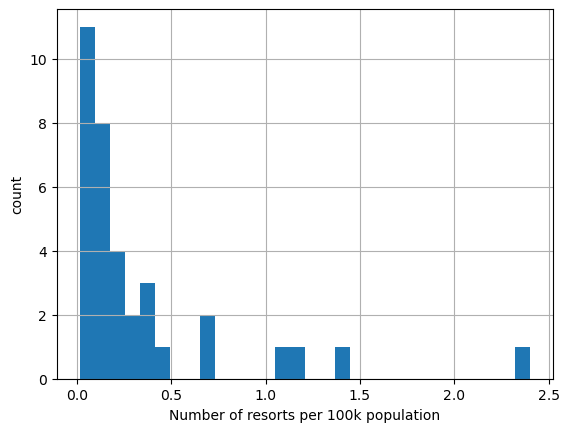

In [12]:
state_summary.resorts_per_100kcapita.hist(bins=30)
plt.xlabel('Number of resorts per 100k population')
plt.ylabel('count');

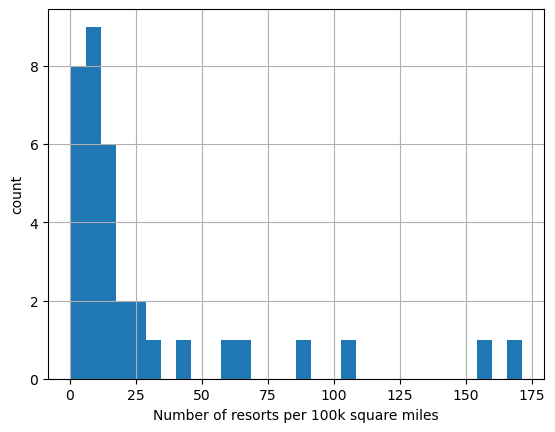

In [13]:
state_summary.resorts_per_100ksq_mile.hist(bins=30)
plt.xlabel('Number of resorts per 100k square miles')
plt.ylabel('count');

Again, we can look at the new standardized columns by descending value:

In [14]:
state_summary.set_index('state').resorts_per_100kcapita.sort_values(ascending=False).head()
state_summary.set_index('state').resorts_per_100ksq_mile.sort_values(ascending=False).head()

state
New Hampshire    171.141299
Vermont          155.990017
Massachusetts    104.225886
Connecticut       90.203861
Rhode Island      64.724919
Name: resorts_per_100ksq_mile, dtype: float64

### 3. To visualize high dimensional  data, Principle Components Analysis (PCA) can be used.

Linear combinations of the original features that are uncorrelated with one another are ordered by variance.  This will lower the dimensions and reveal how much variance is present.

The basic steps in this process are:

1. scale the data (important here because our features are heterogenous)
2. fit the PCA transformation (learn the transformation from the data)
3. apply the transformation to the data to create the derived features
4. (optionally) use the derived features to look for patterns in the data and explore the coefficients

First re-index appropriately, save the columns and the index, [scale](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html) the data, and create a the new DataFrame:

In [15]:
state_summary_scale = state_summary.set_index('state')
state_summary_index = state_summary_scale.index
state_summary_cols = state_summary_scale.columns
state_summary_scale = scale(state_summary_scale)
state_summary_scaled_df = pd.DataFrame(state_summary_scale, columns=state_summary_cols)
state_summary_scaled_df.head()

,resorts_per_state,state_total_skiable_area_ac,state_total_days_open,state_total_terrain_parks,state_total_nightskiing_ac,resorts_per_100kcapita,resorts_per_100ksq_mile
0,-0.804907,-0.392424,-0.689059,-0.815308,0.067082,0.138032,-0.691870
1,-0.930115,-0.462844,-0.819038,-0.727098,-0.702208,-0.646444,-0.659992
2,1.448833,1.978407,2.190933,2.580758,0.077852,-0.593811,-0.389203
3,1.574041,3.754827,2.816757,2.272025,-0.166782,0.080495,-0.186102
4,-0.554492,-0.584952,-0.679431,-0.550679,-0.431418,-0.415243,1.502797


Fitting the PCA transformation and plotting the cumulative variance ratio with the number of components:

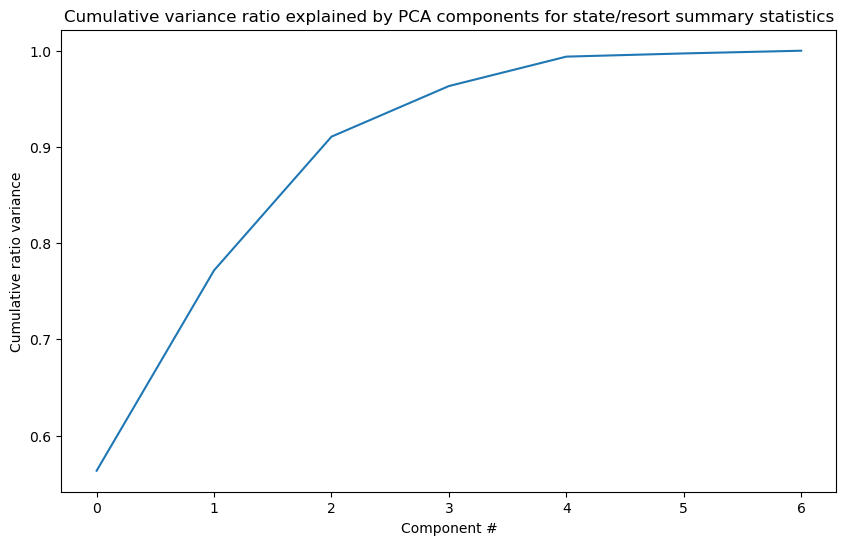

In [16]:
state_pca = PCA().fit(state_summary_scale)

plt.subplots(figsize=(10, 6))
plt.plot(state_pca.explained_variance_ratio_.cumsum())
plt.xlabel('Component #')
plt.ylabel('Cumulative ratio variance')
plt.title('Cumulative variance ratio explained by PCA components for state/resort summary statistics');

Applying the transformation to the data to obtain derived features and plotting the first two derived features:

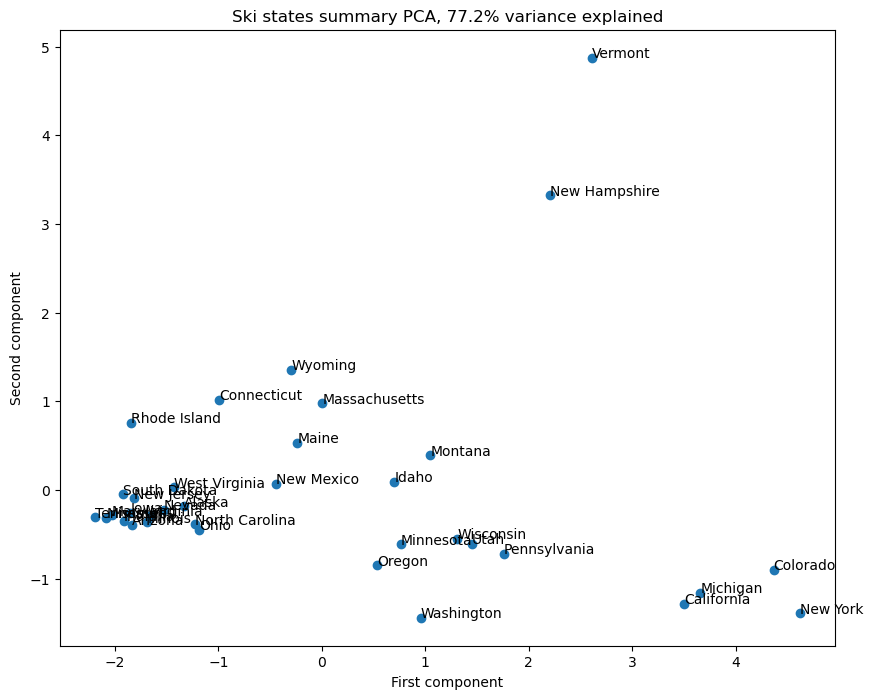

In [17]:
state_pca_x = state_pca.transform(state_summary_scale)

x = state_pca_x[:, 0]
y = state_pca_x[:, 1]
state = state_summary_index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
plt.subplots(figsize=(10,8))
plt.scatter(x=x, y=y)
plt.xlabel('First component')
plt.ylabel('Second component')
plt.title(f'Ski states summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))

### 4. Further Data Analysis

In [18]:
# Grouping to produce summary statistic and converting to DataFrame example:
state_avg_price = ski_data.groupby('state')['AdultWeekend'].mean().to_frame()
state_avg_price.head()

,AdultWeekend
state,
Alaska,57.333333
Arizona,83.500000
California,81.416667
Colorado,90.714286
Connecticut,56.800000


In [19]:
# Creating a new dataframe with the first 2 PCA components
pca_df = pd.DataFrame({'PC1': state_pca_x[:, 0], 'PC2': state_pca_x[:, 1]}, index=state_summary_index)
pca_df.head()

,PC1,PC2
state,,
Alaska,-1.336003,-0.182775
Arizona,-1.838939,-0.391301
California,3.504244,-1.282755
Colorado,4.365491,-0.896803
Connecticut,-0.989839,1.018582


In [20]:
# Merging the above DataFrames
pca_df = pd.concat([pca_df, state_avg_price], axis=1)
pca_df.head()

,PC1,PC2,AdultWeekend
state,,,
Alaska,-1.336003,-0.182775,57.333333
Arizona,-1.838939,-0.391301,83.500000
California,3.504244,-1.282755,81.416667
Colorado,4.365491,-0.896803,90.714286
Connecticut,-0.989839,1.018582,56.800000


In [21]:
# Adding a column which reveals which quartile row is in:
pca_df['Quartile'] = pd.qcut(pca_df.AdultWeekend, q=4, precision=1)
pca_df.head()

,PC1,PC2,AdultWeekend,Quartile
state,,,,
Alaska,-1.336003,-0.182775,57.333333,"(53.0, 60.4]"
Arizona,-1.838939,-0.391301,83.500000,"(78.4, 93.0]"
California,3.504244,-1.282755,81.416667,"(78.4, 93.0]"
Colorado,4.365491,-0.896803,90.714286,"(78.4, 93.0]"
Connecticut,-0.989839,1.018582,56.800000,"(53.0, 60.4]"


In [22]:
# Checking if there are null columns.
pca_df[pca_df.isnull().any(axis=1)]

,PC1,PC2,AdultWeekend,Quartile
state,,,,
Rhode Island,-1.84115,0.758605,NaN,NaN


In [23]:
# Correcting data issues accordingly
pca_df['AdultWeekend'].fillna(pca_df.AdultWeekend.mean(), inplace=True)
pca_df['Quartile'] = pca_df['Quartile'].cat.add_categories('NA')
pca_df['Quartile'].fillna('NA', inplace=True)
pca_df.loc['Rhode Island']

PC1             -1.84115
PC2             0.758605
AdultWeekend    64.10172
Quartile              NA
Name: Rhode Island, dtype: object

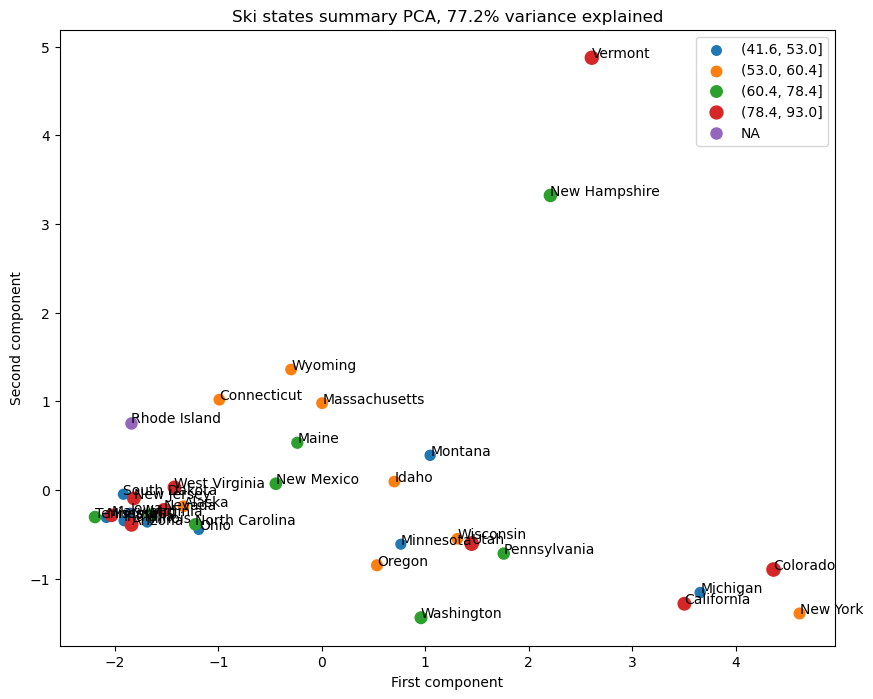

In [24]:
# Creating scatterplot based on quartiles
x = pca_df.PC1
y = pca_df.PC2
price = pca_df.AdultWeekend
quartiles = pca_df.Quartile
state = pca_df.index
pc_var = 100 * state_pca.explained_variance_ratio_.cumsum()[1]
fig, ax = plt.subplots(figsize=(10,8))
for q in quartiles.cat.categories:
    im = quartiles == q
    ax.scatter(x=x[im], y=y[im], s=price[im], label=q)
ax.set_xlabel('First component')
ax.set_ylabel('Second component')
plt.legend()
ax.set_title(f'Ski states summary PCA, {pc_var:.1f}% variance explained')
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))

Using Seaborn to accomplish the above much easily:

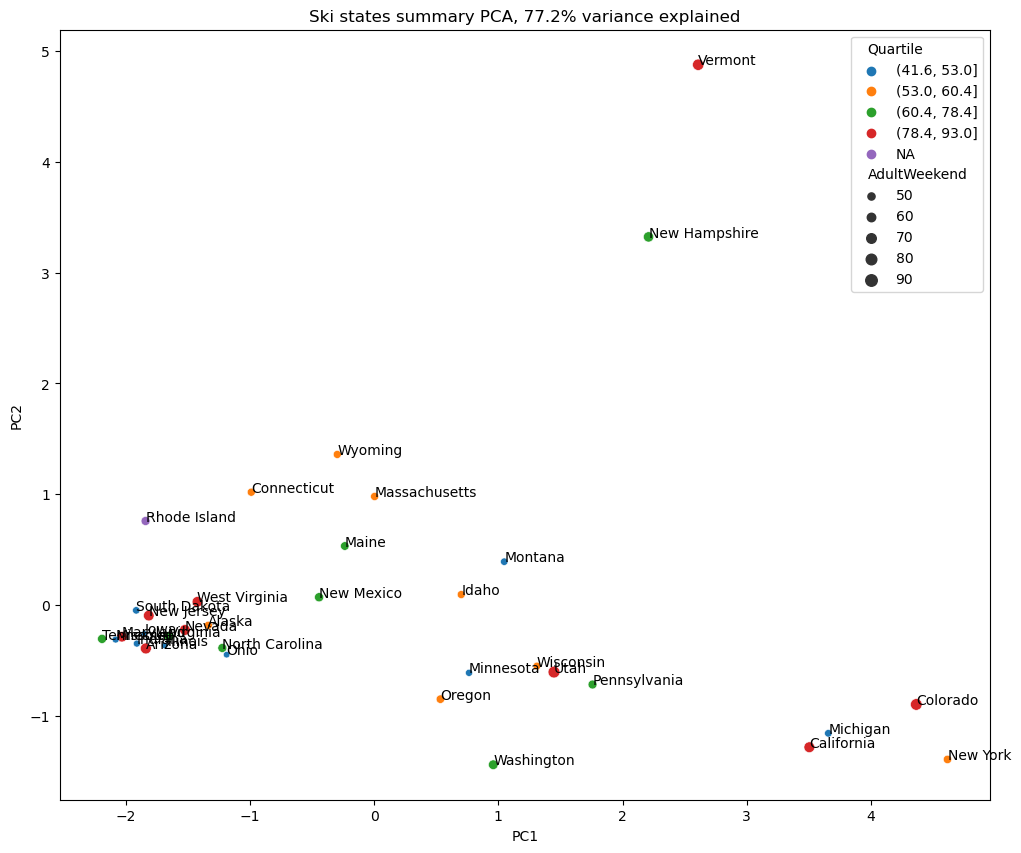

In [25]:
#Create a seaborn scatterplot by calling `sns.scatterplot`
#Specify the dataframe pca_df as the source of the data,
#specify 'PC1' for x and 'PC2' for y,
#specify 'AdultWeekend' for the pointsize (scatterplot's `size` argument),
#specify 'Quartile' for `hue`
#specify pca_df.Quartile.cat.categories for `hue_order` - what happens with/without this?
x = pca_df.PC1
y = pca_df.PC2
state = pca_df.index
plt.subplots(figsize=(12, 10))
# Note the argument below to make sure we get the colours in the ascending
# order we intuitively expect!
sns.scatterplot(x='PC1', y='PC2', size='AdultWeekend', hue='Quartile', 
                hue_order=pca_df.Quartile.cat.categories, data=pca_df)
#and we can still annotate with the state labels
for s, x, y in zip(state, x, y):
    plt.annotate(s, (x, y))   
plt.title(f'Ski states summary PCA, {pc_var:.1f}% variance explained');

## Pre-Processing and Training Data

Cases of when or when not to scale:
1. k-nearest neighbors with an Euclidean distance measure is sensitive to magnitudes and hence should be scaled for all features to weigh in equally.
2. Scaling is critical, while performing Principal Component Analysis(PCA). PCA tries to get the features with maximum variance and the variance is high for high magnitude features. This skews the PCA towards high magnitude features.
3. We can speed up gradient descent by scaling. This is because θ will descend quickly on small ranges and slowly on large ranges, and so will oscillate inefficiently down to the optimum when the variables are very uneven.
4. Tree based models are not distance based models and can handle varying ranges of features. Hence, Scaling is not required while modelling trees.
5. Algorithms like Linear Discriminant Analysis(LDA), Naive Bayes are by design equipped to handle this and gives weights to the features accordingly. Performing a features scaling in these algorithms may not have much effect.

In [28]:
import pandas as pd
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import __version__ as sklearn_version
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, learning_curve
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectKBest, f_regression
import datetime

from library.sb_utils import save_file

ski_data = pd.read_csv('../data/ski_data_step3_features.csv')

In [29]:
ski_data.head()

,Name,Region,state,summit_elev,vertical_drop,base_elev,trams,fastSixes,fastQuads,quad,...,resorts_per_100kcapita,resorts_per_100ksq_mile,resort_skiable_area_ac_state_ratio,resort_days_open_state_ratio,resort_terrain_park_state_ratio,resort_night_skiing_state_ratio,total_chairs_runs_ratio,total_chairs_skiable_ratio,fastQuads_runs_ratio,fastQuads_skiable_ratio
0,Alyeska Resort,Alaska,Alaska,3939,2500,250,1,0,2,2,...,0.410091,0.450867,0.706140,0.434783,0.500000,0.948276,0.092105,0.004348,0.026316,0.001242
1,Eaglecrest Ski Area,Alaska,Alaska,2600,1540,1200,0,0,0,0,...,0.410091,0.450867,0.280702,0.130435,0.250000,NaN,0.111111,0.006250,0.000000,0.000000
2,Hilltop Ski Area,Alaska,Alaska,2090,294,1796,0,0,0,0,...,0.410091,0.450867,0.013158,0.434783,0.250000,0.051724,0.230769,0.100000,0.000000,0.000000
3,Arizona Snowbowl,Arizona,Arizona,11500,2300,9200,0,1,0,2,...,0.027477,1.754540,0.492708,0.514768,0.666667,NaN,0.145455,0.010296,0.000000,0.000000
4,Sunrise Park Resort,Arizona,Arizona,11100,1800,9200,0,0,1,2,...,0.027477,1.754540,0.507292,0.485232,0.333333,1.000000,0.107692,0.008750,0.015385,0.001250


In [30]:
big_mountain = ski_data[ski_data.Name == 'Big Mountain Resort']
ski_data = ski_data[ski_data.Name != 'Big Mountain Resort']

### Partitioning training and testing splits.

In [31]:
# Examning number of elements in 70-30 train-test split.
len(ski_data) * .7, len(ski_data) * .3

(194.6, 83.39999999999999)

In [32]:
# Partitioning data
X_train, X_test, y_train, y_test = train_test_split(ski_data.drop(columns='AdultWeekend'), 
                                                    ski_data.AdultWeekend, test_size=0.3, 
                                                    random_state=47)

In [46]:
# looking at shape
print ('x training:',str(X_train.shape))
print ('x testing:',str(X_test.shape))
print ('y training:',str(y_train.shape))
print ('y testing:',str(y_test.shape))

x training: (194, 35)
x testing: (84, 35)
y training: (194,)
y testing: (84,)


In [49]:
# Checking for non-numerical columns in x
X_train.dtypes, X_test.dtypes

(Name                                   object
 Region                                 object
 state                                  object
 summit_elev                             int64
 vertical_drop                           int64
 base_elev                               int64
 trams                                   int64
 fastSixes                               int64
 fastQuads                               int64
 quad                                    int64
 triple                                  int64
 double                                  int64
 surface                                 int64
 total_chairs                            int64
 Runs                                  float64
 TerrainParks                          float64
 LongestRun_mi                         float64
 SkiableTerrain_ac                     float64
 Snow Making_ac                        float64
 daysOpenLastYear                      float64
 yearsOpen                             float64
 averageSnowf

In [50]:
# Dropping non-numerical columns
names_list = ['Name', 'state', 'Region']
names_train = X_train[names_list]
names_test = X_test[names_list]
X_train.drop(columns=names_list, inplace=True)
X_test.drop(columns=names_list, inplace=True)
X_train.shape, X_test.shape

((194, 32), (84, 32))

### Determining how good the mean is as a predictor

In [53]:
# Calculating the mean of `y_train`
train_mean = y_train.mean()
print('training mean', train_mean)

# Fitting a dummy regressor on the training data
dumb_reg = DummyRegressor(strategy='mean')
dumb_reg.fit(X_train, y_train)
print ('regressor coefficient:',dumb_reg.constant_[0][0])

training mean 63.909948453608244
regressor coefficient: 63.909948453608244


### Caclulating R-squared (Coefficient of Determination)

In [54]:
def r_squared(y, ypred):
    """R-squared score.
    
    Calculate the R-squared, or coefficient of determination, of the input.
    
    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    ybar = np.sum(y) / len(y) #yes, we could use np.mean(y)
    sum_sq_tot = np.sum((y - ybar)**2) #total sum of squares error
    sum_sq_res = np.sum((y - ypred)**2) #residual sum of squares error
    R2 = 1.0 - sum_sq_res / sum_sq_tot
    return R2

In [55]:
y_tr_pred = dumb_reg.predict(X_train)
r_squared(y_train, y_tr_pred)

0.0

In [58]:
y_te_pred = train_mean * np.ones(len(y_test))
r_squared(y_test, y_te_pred)

-0.000719221815450588

### Calculating Mean Absolute Error

In [56]:
def mae(y, ypred):
    """Mean absolute error.
    
    Calculate the mean absolute error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    abs_error = np.abs(y - ypred)
    mae = np.mean(abs_error)
    return mae

In [59]:
print ('training:', mae(y_train, y_tr_pred))
print ('testing:', mae(y_test, y_te_pred))

training: 18.04973695398023
testing: 18.7889236622484


### Calculating Mean Squared Error

In [60]:
def mse(y, ypred):
    """Mean square error.
    
    Calculate the mean square error of the arguments

    Arguments:
    y -- the observed values
    ypred -- the predicted values
    """
    sq_error = (y - ypred)**2
    mse = np.mean(sq_error)
    return mse

In [61]:
print ('training:', mse(y_train, y_tr_pred))
print ('testing:', mse(y_test, y_te_pred))

training: 608.2790850488891
testing: 587.310332452338


In [63]:
# Calculating the root mean square error
np.sqrt([mse(y_train, y_tr_pred), mse(y_test, y_te_pred)])

array([24.66331456, 24.23448643])

### Using Scikit's Implementations of Metrics
You can check function syntax with the `func?` call.

In [64]:
r2_score(y_train, y_tr_pred), r2_score(y_test, y_te_pred)

(0.0, -0.000719221815450588)

In [65]:
mean_absolute_error(y_train, y_tr_pred), mean_absolute_error(y_test, y_te_pred)

(18.04973695398023, 18.7889236622484)

In [66]:
mean_squared_error(y_train, y_tr_pred), mean_squared_error(y_test, y_te_pred)

(608.2790850488893, 587.3103324523379)